# HealthInsight — Simple ML

**Goal:** Proving we can train an ML model on our health data and predict patient risk.

**Approach:**
- Load vitals + alerts from Cassandra
- Build simple per-patient features (avg vitals over last day)
- Train: LogisticRegression
- Output: risk ranking

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')
np.random.seed(42)

## 1) Load data from Cassandra

In [2]:
# Connect to Cassandra and load last 24h of data
cluster = Cluster(['127.0.0.1'], port=9042)
session = cluster.connect('health_insight')

# Time window: last 24 hours
cutoff = datetime.utcnow() - timedelta(hours=24)

# Patient IDs (match your generator)
patient_ids = [f"P-{i:03d}" for i in range(1, 21)]

# Load vitals
vitals_rows = []
for pid in patient_ids:
    query = "SELECT patient_id, timestamp, metric_name, value FROM patient_vitals WHERE patient_id=%s AND timestamp >= %s"
    for row in session.execute(query, (pid, cutoff)):
        vitals_rows.append({
            'patient_id': row.patient_id,
            'timestamp': row.timestamp,
            'metric_name': row.metric_name,
            'value': float(row.value)
        })

vitals_df = pd.DataFrame(vitals_rows)

# Load alerts
alerts_rows = []
for pid in patient_ids:
    query = "SELECT patient_id, timestamp, status FROM health_alerts_by_patient WHERE patient_id=%s AND timestamp >= %s"
    for row in session.execute(query, (pid, cutoff)):
        if row.status and row.status.upper() == 'ACTIVE':
            alerts_rows.append({'patient_id': row.patient_id})

alerts_df = pd.DataFrame(alerts_rows)

cluster.shutdown()

print(f"Loaded {len(vitals_df)} vitals rows, {len(alerts_df)} alerts")
vitals_df.head()

Loaded 26400 vitals rows, 216 alerts


,patient_id,timestamp,metric_name,value
0,P-001,2025-12-28 17:53:36,bp_diastolic,71.80
1,P-001,2025-12-28 17:53:36,bp_systolic,121.91
2,P-001,2025-12-28 17:53:36,heart_rate,76.15
3,P-001,2025-12-28 17:53:36,respiratory_rate,12.30
4,P-001,2025-12-28 17:53:36,spo2,98.85


## 2) Build simple features per patient

In [3]:
# Compute average vital per patient (pivot wide)
features = vitals_df.groupby(['patient_id', 'metric_name'])['value'].mean().unstack(fill_value=0)

# Simple label: split by median heart_rate (above median = high risk)
# This guarantees balanced classes for demo purposes
data = features.reset_index()

if 'heart_rate' in data.columns:
    median_hr = data['heart_rate'].median()
    data['high_risk'] = (data['heart_rate'] > median_hr).astype(int)
else:
    # Fallback: use first available metric
    first_metric = data.columns[1]  # skip patient_id
    median_val = data[first_metric].median()
    data['high_risk'] = (data[first_metric] > median_val).astype(int)

print(f"Features: {list(features.columns)}")
print(f"Label distribution: {data['high_risk'].value_counts().to_dict()}")
data.head()

Features: ['bp_diastolic', 'bp_systolic', 'heart_rate', 'respiratory_rate', 'spo2', 'temperature']
Label distribution: {0: 10, 1: 10}


metric_name,patient_id,bp_diastolic,bp_systolic,heart_rate,respiratory_rate,spo2,temperature,high_risk
0,P-001,78.418727,121.615455,80.953500,15.060364,97.448136,37.062682,0
1,P-002,77.850364,119.339045,81.386591,15.279545,97.225045,37.068136,1
2,P-003,78.194591,120.874136,80.604682,15.365091,97.365000,37.043227,0
3,P-004,79.170545,122.614273,81.249227,15.377591,97.443364,36.990227,1
4,P-005,77.912409,122.716182,80.414136,15.009045,97.441136,37.032091,0


## 3) Train a simple LogisticRegression model

In [4]:
# Split train/test
X = data.drop(columns=['patient_id', 'high_risk'])
y = data['high_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Score
if len(np.unique(y_test)) > 1:
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC: {auc:.3f}")
else:
    print("Only one class in test set, AUC not defined")
    
print(f"Train accuracy: {model.score(X_train, y_train):.3f}")
print(f"Test accuracy: {model.score(X_test, y_test):.3f}")

ROC-AUC: 1.000
Train accuracy: 1.000
Test accuracy: 0.833


## 4) Visualize: ROC curve + Feature importance

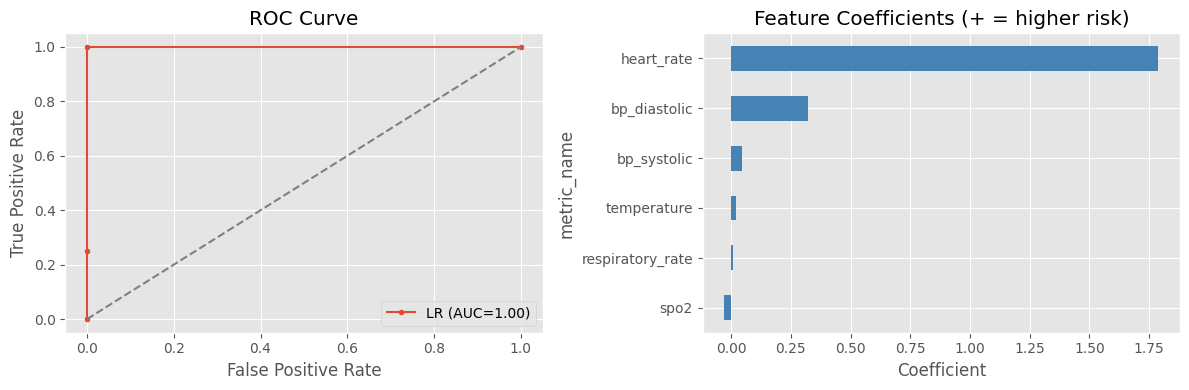

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ROC curve
if len(np.unique(y_test)) > 1:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[0].plot(fpr, tpr, marker='.', label=f'LR (AUC={auc:.2f})')
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()
else:
    axes[0].text(0.5, 0.5, 'ROC undefined\n(only 1 class)', ha='center', va='center')
    axes[0].set_title('ROC Curve')

# Feature importance (coefficients)
coef = pd.Series(model.coef_[0], index=X.columns).sort_values()
coef.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Feature Coefficients (+ = higher risk)')
axes[1].set_xlabel('Coefficient')

plt.tight_layout()
plt.show()

## 5) Output: Risk ranking for all patients


🚨 Top 10 high-risk patients:


,patient_id,predicted_risk,actual_high_risk
18,P-019,0.852805,1
9,P-010,0.780367,1
13,P-014,0.745334,1
11,P-012,0.703053,1
16,P-017,0.694157,1
5,P-006,0.682542,1
3,P-004,0.594799,1
8,P-009,0.585066,1
1,P-002,0.517076,1
17,P-018,0.462369,1


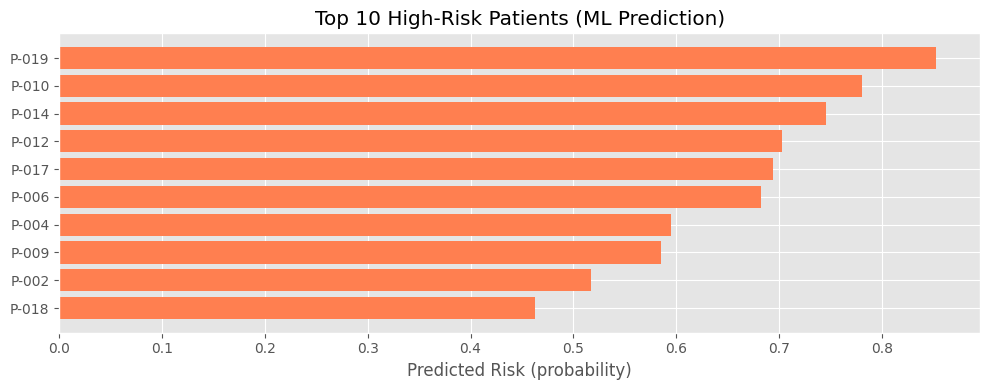


✅ Saved risk scores to outputs/patient_risk_scores.csv


In [6]:
# Predict risk for all patients
X_all = data.drop(columns=['patient_id', 'high_risk'])
risk_scores = model.predict_proba(X_all)[:, 1]

# Create risk table
risk_df = pd.DataFrame({
    'patient_id': data['patient_id'],
    'predicted_risk': risk_scores,
    'actual_high_risk': data['high_risk']
}).sort_values('predicted_risk', ascending=False)

print("\n🚨 Top 10 high-risk patients:")
display(risk_df.head(10))

# Bar chart of top 10
plt.figure(figsize=(10, 4))
top10 = risk_df.head(10).iloc[::-1]
plt.barh(top10['patient_id'], top10['predicted_risk'], color='coral')
plt.xlabel('Predicted Risk (probability)')
plt.title('Top 10 High-Risk Patients (ML Prediction)')
plt.tight_layout()
plt.show()

# Save to CSV
risk_df.to_csv('outputs/patient_risk_scores.csv', index=False)
print("\n✅ Saved risk scores to outputs/patient_risk_scores.csv")